# **IMPORTING REAL DATA**

data source :
https://www.youtube.com/watch?v=Q3wmyxTHg8s&list=LL&index=2

In [ ]:
from google.colab import drive
import pandas as pd
#import the .csv file containning real data
df1 = pd.read_csv('/content/drive/MyDrive/Warfarin-drug/Physics infoemed DeepONet/final-code/simulatedData.csv')
df1

,ID,TIME,DV,AMOUNT
0,1,0.0,.,500
1,1,0.5,5.15083,.
2,1,1.0,4.38285,.
3,1,1.5,3.95729,.
4,1,2.0,3.25193,.
...,...,...,...,...
147,19,1.5,1.73864,.
148,19,2.0,1.35909,.
149,19,4.0,0.644789,.
150,19,6.0,0.226286,.


In [ ]:
# Select rows from index 0 (time = 0) to index 42 (time = 144)
df2 = df1.iloc[0:8]
df2

,ID,TIME,DV,AMOUNT
0,1,0.0,.,500
1,1,0.5,5.15083,.
2,1,1.0,4.38285,.
3,1,1.5,3.95729,.
4,1,2.0,3.25193,.
5,1,4.0,1.11937,.
6,1,6.0,0.186841,.
7,1,8.0,0.05,.


In [ ]:
#only "TIME" column
df_time = df2[['TIME']]
df_time

,TIME
0,0.0
1,0.5
2,1.0
3,1.5
4,2.0
5,4.0
6,6.0
7,8.0


In [ ]:
#only "CONC" column
df_cc = df2[['DV']]
df_cc

,DV
0,.
1,5.15083
2,4.38285
3,3.95729
4,3.25193
5,1.11937
6,0.186841
7,0.05


In [ ]:
df_cc.iloc[0] = 0

<ipython-input-138-cb0d003ba57c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cc.iloc[0] = 0


In [ ]:
df_cc

,DV
0,0
1,5.15083
2,4.38285
3,3.95729
4,3.25193
5,1.11937
6,0.186841
7,0.05


In [ ]:
type(df_time)   #our data is dataframe

pandas.core.frame.DataFrame

In [ ]:
# Convert data from dataframe to numpyarray
time_data = df_time.to_numpy()
cc_data = df_cc.to_numpy()
type(time_data)

numpy.ndarray

In [ ]:
time_data.shape

(8, 1)

In [ ]:
# Save as .csv file
#df_time.to_csv('/content/drive/MyDrive/stage: multiverse Nouha/final/time.csv', index=False)
#df_cc.to_csv('/content/drive/MyDrive/stage: multiverse Nouha/final/concentration.csv', index=False)

# **Training & Predictions** of Physics-Informed DeepONets model

The complete code involves **training** a PIDeepONet model for solving ODEs/PDEs and generating **predictions**. This code follow the process of:

1. Defining the model architecture using TensorFlow.
2. Creating synthetic data for training, validation, and testing.
3. Training the model using the training dataset with a specified loss function and optimization.
4. Visualizing the loss convergence during training.
5. Making predictions on the test dataset and evaluating the model's performance.    

# **1. Defining the model architecture using TensorFlow.**

In [ ]:
# Import Dependencies: Importing the required libraries such as NumPy, TensorFlow, Matplotlib, and others.
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
tf.random.set_seed(42)
from pathlib import Path
from sklearn.model_selection import train_test_split
from collections import defaultdict
from tqdm import tqdm
import time
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from scipy.integrate import solve_ivp
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error

In [ ]:
#Define Model's Architecture: The create_model function is defined to create the architecture of the Physics-informed DeepONet model. It consists of a branch and trunk network, which are combined to calculate the model's output.
def create_model(mean, var, verbose=False):
    """Definition of a DeepONet with fully connected branch and trunk layers.

    Args:
    ----
    mean: dictionary, mean values of the inputs
    var: dictionary, variance values of the inputs
    verbose: boolean, indicate whether to show the model summary

    Outputs:
    --------
    model: the DeepONet model
    """

    # Branch net
    branch_input = tf.keras.Input(shape=(len(mean['cc'])), name="cc")
    branch = tf.keras.layers.Normalization(mean=mean['cc'], variance=var['cc'])(branch_input)
    for i in range(3):
        branch = tf.keras.layers.Dense(50, activation="tanh")(branch)

    # Trunk net
    trunk_input = tf.keras.Input(shape=(len(mean['time'])), name="time")
    trunk = tf.keras.layers.Normalization(mean=mean['time'], variance=var['time'])(trunk_input)
    for i in range(3):
        trunk = tf.keras.layers.Dense(50, activation="tanh")(trunk)

    # Compute the dot product between branch and trunk net
    dot_product = tf.reduce_sum(tf.multiply(branch, trunk), axis=1, keepdims=True)

    # Add the bias
    output = BiasLayer()(dot_product)

    # Create the model
    model = tf.keras.models.Model(inputs=[branch_input, trunk_input], outputs=output)

    if verbose:
        model.summary()

    return model

In [ ]:
# Define Custom Layer: The BiasLayer class is defined as a custom Keras layer to add a bias term to the model's output.
class BiasLayer(tf.keras.layers.Layer):
    def build(self, input_shape):
        self.bias = self.add_weight(shape=(1,),
                                    initializer=tf.keras.initializers.Zeros(),
                                    trainable=True)
    def call(self, inputs):
        return inputs + self.bias

In [ ]:
#The ODE_residual_calculator function calculates the residual of the governing ordinary differential equation (ODE) based on the model's output and its derivatives."""

@tf.function # we use @tf.function => to convert the regular python function into a Tensorflow graph BECAUSE gradient calculation can be quite expensive !
def ODE_residual_calculator(t, u, u_t, model):
    """ODE residual calculation.
    Args:
    ----
    t: temporal coordinate
    u: input function evaluated at discrete temporal coordinates
    u_t: input function evaluated at t
    model: DeepONet model
    Outputs:
    --------
    ODE_residual: residual of the governing ODE
    """
    with tf.GradientTape() as tape:
        tape.watch(t)
        s = model({"cc": u, "time": t}) # Forward running of the DeepONet model : we give the model ({"cc": u, "time": t}) and it outputs : s

    # Calculate gradients
    ds_dt = tape.gradient(s, t) # Calculate the gradient of s(.) at t & track all operations that involve t

    # ODE residual
    ODE_residual = ds_dt - u_t # calculates the residual of the governing ordinary differential equation (ODE) based on the model's output and its derivatives.

    return ODE_residual

In [ ]:
# Define Training Step: The train_step function computes the gradients of the total loss with respect to the model's parameters for a given batch of training data. It also calculates the individual losses for initial conditions (IC) and ODE residuals.
@tf.function
def train_step(X, X_init, IC_weight, ODE_weight, model):
    """Calculate gradients of the total loss with respect to network model parameters.
    Args:
    ----
    X: training dataset for evaluating ODE residuals
    X_init: training dataset for evaluating initial conditions
    IC_weight: weight for initial condition loss
    ODE_weight: weight for ODE loss
    model: DeepONet model
    Outputs:
    --------
    ODE_loss: calculated ODE loss
    IC_loss: calculated initial condition loss
    total_loss: weighted sum of ODE loss and initial condition loss
    gradients: gradients of the total loss with respect to network model parameters.
    """
    with tf.GradientTape() as tape:
        tape.watch(model.trainable_weights)

        # Initial condition prediction
        y_pred_IC = model({"cc": X_init[:, 1:-1], "time": X_init[:, :1]})

        # Equation residual
        ODE_residual = ODE_residual_calculator(t=X[:, :1], u=X[:, 1:-1], u_t=X[:, -1:], model=model)

        # Calculate loss
        IC_loss = tf.reduce_mean(keras.losses.mean_squared_error(0, y_pred_IC))
        ODE_loss = tf.reduce_mean(tf.square(ODE_residual))

        # Total loss
        total_loss = IC_loss*IC_weight + ODE_loss*ODE_weight

    gradients = tape.gradient(total_loss, model.trainable_variables)

    return ODE_loss, IC_loss, total_loss, gradients

# **2. Creating synthetic data from our "cc_data" for training, validation, and testing.**

**Generate Synthetic Data**: Functions like **create_samples** and **generate_dataset** are defined to generate synthetic data for training, validation, and testing. These data include input profiles, time points, and corresponding ODE solutions.

In [ ]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

#This function generates synthetic data for the input profiles (u(·)) using a Gaussian Process Regressor (GPR) with a given length scale.
#It generates a specified number of u(·) profiles by sampling from the prior distribution defined by the GPR kernel.
def create_samples(length_scale, sample_num):
    """Create synthetic data for u(·)
    Args:
    ----
    length_scale: float, length scale for RNF kernel
    sample_num: number of u(·) profiles to generate
    Outputs:
    --------
    u_sample: generated u(·) profiles
    """
    # Define kernel with given length scale
    kernel = RBF(length_scale)

    # Create Gaussian process regressor
    gp = GaussianProcessRegressor(kernel=kernel)

    # Our Concentration data
    X_sample = cc_data

    # Create samples
    u_sample = np.zeros((sample_num, 8))#+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
    for i in range(sample_num):
        # sampling from the prior directly
        n = np.random.randint(0, 64)
        u_sample[i, :] = gp.sample_y(X_sample, random_state=n).flatten()

    return u_sample

In [ ]:
from tqdm import tqdm
from scipy.integrate import solve_ivp

#This function generates a dataset for Physics-informed DeepONet training.
#It creates random fields (u(·) profiles) using the create_samples function and compiles a dataset of t, u(·) profiles, and u(t).
#Optionally, if ODE_solve is set to True, it also computes the corresponding ODE solution s(·) using the solve_ivp function
def generate_dataset(N, length_scale, ODE_solve=False):
    """Generate dataset for Physics-informed DeepONet training.
    Args:
    ----
    N: int, number of u(·) profiles
    length_scale: float, length scale for RNF kernel
    ODE_solve: boolean, indicate whether to compute the corresponding s(·)
    Outputs:
    --------
    X: the dataset for t, u(·) profiles, and u(t)
    y: the dataset for the corresponding ODE solution s(·)
    """
    # Create random fields
    random_field = create_samples(length_scale, N)

    # Compile dataset
    X = np.zeros((N*8, 8+2))
    y = np.zeros((N*8, 1))

    for i in tqdm(range(N)):

        u = np.tile(random_field[i, :], (8, 1))

        t = time_data

        # u(·) evaluated at t
        u_t = np.diag(u).reshape(-1, 1)

        # Update overall matrix
        X[i*8:(i+1)*8, :] = np.concatenate((t, u, u_t), axis=1)

        # Solve ODE
        t_unique_values = np.unique(t)                                            # time unique values
        if ODE_solve:
            sol = solve_ivp(lambda var_t, var_s: np.interp(var_t, t.flatten(), random_field[i, :]),
                            t_span=[t[0], t[-1]], y0=[0], t_eval=t_unique_values.flatten(), method='RK45') # using time unique values & t[0], t[-1] in place of [0,1]
            y[i*8:(i+1)*8, :] = sol.y[0].reshape(-1, 1)

    return X, y

In [ ]:
# Create training dataset
N_train = 2000
length_scale_train = 0.4
X_train, y_train = generate_dataset(N_train, length_scale_train)

# Create validation dataset
N_val = 100
length_scale_test = 0.4
X_val, y_val = generate_dataset(N_val, length_scale_test)

# Create testing dataset
N_test = 100
length_scale_test = 0.4
X_test, y_test = generate_dataset(N_test, length_scale_test, ODE_solve=True)

100%|██████████| 100/100 [00:00<00:00, 209.11it/s]


In [ ]:
X_train.shape

(16000, 10)

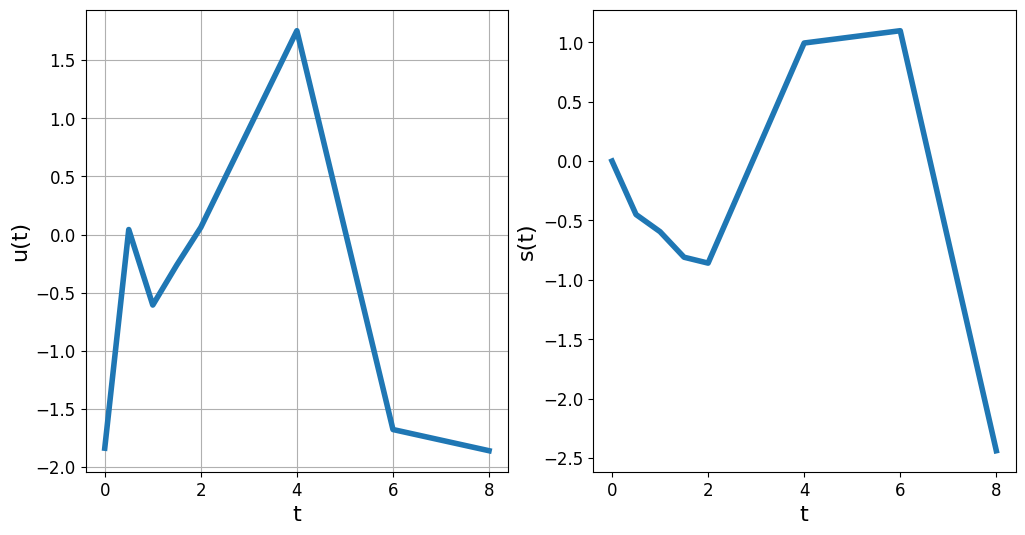

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
index = 25
ax[0].plot(time_data.flatten(), X_test[index*8, 1:-1], lw=4)
ax[0].set_xlabel('t', fontsize=16)
ax[0].set_ylabel('u(t)', fontsize=16) # input u(t)
ax[0].tick_params(axis='both', which='major', labelsize=12)
ax[0].grid(True)

ax[1].plot(time_data.flatten(), y_test[index*8:(index+1)*8], lw=4)
ax[1].set_xlabel('t', fontsize=16)
ax[1].set_ylabel('s(t)', fontsize=16) # solution : output
ax[1].tick_params(axis='both', which='major', labelsize=12)

In [ ]:
# Determine batch size
ini_batch_size = int(2000/8)
col_batch_size = 2000

# Create dataset object (initial conditions)
# X_train_ini, ini_ds: The initial conditions dataset object is created using TensorFlow's tf.data.Dataset.from_tensor_slices function.
# It contains initial conditions data, which are samples where the temporal coordinate is 0. The dataset is shuffled and batched for training.
X_train_ini = tf.convert_to_tensor(X_train[X_train[:, 0]==0], dtype=tf.float32)
ini_ds = tf.data.Dataset.from_tensor_slices((X_train_ini))
ini_ds = ini_ds.shuffle(5000).batch(ini_batch_size)


# Create dataset object (collocation points)
# X_train, train_ds: The collocation points dataset object is created using the same approach.
# It includes both the temporal coordinates and u(·) profiles for collocation points. The dataset is shuffled and batched for training.
X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
train_ds = tf.data.Dataset.from_tensor_slices((X_train))
train_ds = train_ds.shuffle(100000).batch(col_batch_size)

# Scaling
# The mean and variance of the input features (cc and time) are calculated to scale the data.
# These statistics are used to normalize the input data in order to improve training stability.
mean = {
    'cc': np.mean(X_train[:, 1:-1], axis=0),
    'time': np.mean(X_train[:, :1], axis=0)
}

var = {
    'cc': np.var(X_train[:, 1:-1], axis=0),
    'time': np.var(X_train[:, :1], axis=0)
}

In [ ]:
# Define Loss Tracking: The LossTracking class helps track and manage the loss values during training.
# It calculates and stores the mean total loss, IC loss, and ODE loss.
from collections import defaultdict

class LossTracking:

    def __init__(self):
        self.mean_total_loss = keras.metrics.Mean()
        self.mean_IC_loss = keras.metrics.Mean()
        self.mean_ODE_loss = keras.metrics.Mean()
        self.loss_history = defaultdict(list)

    def update(self, total_loss, IC_loss, ODE_loss):
        self.mean_total_loss(total_loss)
        self.mean_IC_loss(IC_loss)
        self.mean_ODE_loss(ODE_loss)

    def reset(self):
        self.mean_total_loss.reset_states()
        self.mean_IC_loss.reset_states()
        self.mean_ODE_loss.reset_states()

    def print(self):
        print(f"IC={self.mean_IC_loss.result().numpy():.4e}, \
              ODE={self.mean_ODE_loss.result().numpy():.4e}, \
              total_loss={self.mean_total_loss.result().numpy():.4e}")

    def history(self):
        self.loss_history['total_loss'].append(self.mean_total_loss.result().numpy())
        self.loss_history['IC_loss'].append(self.mean_IC_loss.result().numpy())
        self.loss_history['ODE_loss'].append(self.mean_ODE_loss.result().numpy())

# **3. Training the model using the training dataset with a specified loss**

In [ ]:
# Set up training configurations
# Configure Training Parameters: The training parameters such as the number of epochs, loss weights, and optimizer are set up.
n_epochs = 300
IC_weight= tf.constant(1.0, dtype=tf.float32)
ODE_weight= tf.constant(1.0, dtype=tf.float32)
loss_tracker = LossTracking()
val_loss_hist = []

# One test sample prediction
pred_profiles = []

# Set up optimizer
optimizer = keras.optimizers.Adam(learning_rate=1e-3)

with tf.device("CPU:0"):

    # Instantiate the PINN model
    PI_DeepONet = create_model(mean, var)
    PI_DeepONet.compile(optimizer=optimizer)

    # Configure callbacks
    _callbacks = [keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=30),
                 tf.keras.callbacks.ModelCheckpoint('NN_model.h5', monitor='val_loss', save_best_only=True)]
    callbacks = tf.keras.callbacks.CallbackList(
                    _callbacks, add_history=False, model=PI_DeepONet)

    # Start training process
    # Training Loop: The main training loop runs for the specified number of epochs.
    # It iterates through the training and initial conditions datasets, computes gradients, performs gradient descent, and updates the loss tracking.
    for epoch in range(1, n_epochs + 1):
        print(f"Epoch {epoch}:")

        for X_init, X in zip(ini_ds, train_ds):

            # Calculate gradients
            ODE_loss, IC_loss, total_loss, gradients = train_step(X, X_init,
                                                                IC_weight, ODE_weight,
                                                                PI_DeepONet)
            # Gradient descent
            PI_DeepONet.optimizer.apply_gradients(zip(gradients, PI_DeepONet.trainable_variables))


            # Loss tracking
            loss_tracker.update(total_loss, IC_loss, ODE_loss)

        # Loss summary
        loss_tracker.history()
        loss_tracker.print()
        loss_tracker.reset()

        # Validation
        # Validation and Callbacks: After each epoch, the validation loss is calculated, and callbacks such as learning rate reduction and model checkpointing are applied.
        val_res = ODE_residual_calculator(X_val[:, :1], X_val[:, 1:-1], X_val[:, -1:], PI_DeepONet)
        val_ODE = tf.cast(tf.reduce_mean(tf.square(val_res)), tf.float32)

        X_val_ini = X_val[X_val[:, 0]==0]
        pred_ini_valid = PI_DeepONet.predict({"cc": X_val_ini[:, 1:-1], "time": X_val_ini[:, :1]}, batch_size=12800)
        val_IC = tf.reduce_mean(keras.losses.mean_squared_error(0, pred_ini_valid))
        print(f"val_IC: {val_IC.numpy():.4e}, val_ODE: {val_ODE.numpy():.4e}, lr: {PI_DeepONet.optimizer.lr.numpy():.2e}")


        # Callback at the end of epoch
        callbacks.on_epoch_end(epoch, logs={'val_loss': val_IC+val_ODE})
        val_loss_hist.append(val_IC+val_ODE)

        # Test dataset
        pred_test = PI_DeepONet.predict({"cc": X_test[:, 1:-1], "time": X_test[:, :1]}, batch_size=12800)
        print(f"RMSE: {mean_squared_error(y_test.flatten(), pred_test.flatten(), squared=False)}")

        # Predict on one specific train samples
        sample_id = 25
        pred_profiles.append(PI_DeepONet.predict({"cc": X_test[sample_id*8:(sample_id+1)*8, 1:-1],
                                            "time": X_test[sample_id*8:(sample_id+1)*8, :1]}, batch_size=12800))

        # Re-shuffle dataset
        ini_ds = tf.data.Dataset.from_tensor_slices((X_train_ini))
        ini_ds = ini_ds.shuffle(5000).batch(ini_batch_size)

        train_ds = tf.data.Dataset.from_tensor_slices((X_train))
        train_ds = train_ds.shuffle(100000).batch(col_batch_size)

Epoch 1:
IC=7.7584e-02,               ODE=9.5764e-01,               total_loss=1.0352e+00
1/1 [==============================] - 0s 124ms/step
val_IC: 6.9701e-02, val_ODE: 9.4330e-01, lr: 1.00e-03
1/1 [==============================] - 0s 27ms/step
RMSE: 1.8269634080489559
1/1 [==============================] - 0s 25ms/step
Epoch 2:
IC=3.0388e-02,               ODE=9.2222e-01,               total_loss=9.5261e-01
1/1 [==============================] - 0s 25ms/step
val_IC: 7.7328e-03, val_ODE: 9.4325e-01, lr: 1.00e-03
1/1 [==============================] - 0s 27ms/step
RMSE: 1.7483725492232765
1/1 [==============================] - 0s 28ms/step
Epoch 3:
IC=1.0607e-02,               ODE=8.9338e-01,               total_loss=9.0399e-01
1/1 [==============================] - 0s 29ms/step
val_IC: 9.7163e-03, val_ODE: 8.9590e-01, lr: 1.00e-03
1/1 [==============================] - 0s 33ms/step
RMSE: 1.5686495477034403
1/1 [==============================] - 0s 30ms/step
Epoch 4:
IC=1.1171e-02, 

# Visualize Loss History:

**The history of IC loss, ODE loss, and validation loss is plotted to visualize the training progress. => we plot the loss convergence curves:**

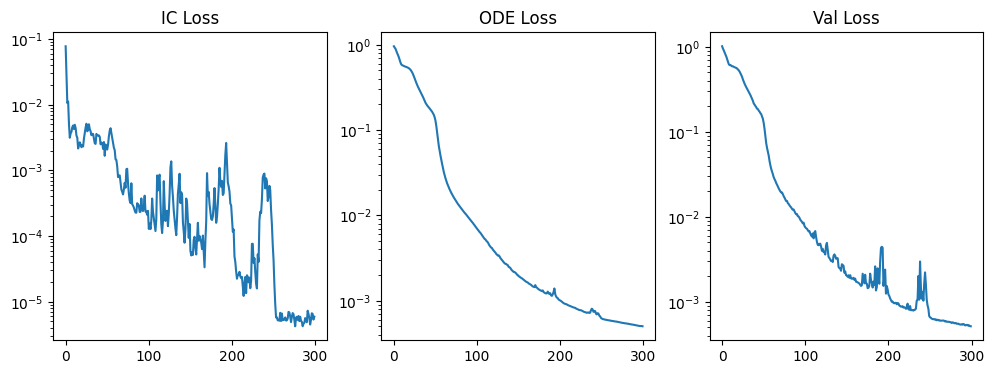

In [ ]:
# History
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
ax[0].plot(range(n_epochs), loss_tracker.loss_history['IC_loss'])
ax[1].plot(range(n_epochs), loss_tracker.loss_history['ODE_loss'])
ax[2].plot(range(n_epochs), val_loss_hist)
ax[0].set_title('IC Loss')
ax[1].set_title('ODE Loss')
ax[2].set_title('Val Loss')
for axs in ax:
    axs.set_yscale('log')

# We can also see how the **prediction accuracy** for **one** specific target s(·) evolves during the training

**Inspect accuracy on test set**

***Load and Evaluate Model: The trained model is loaded from a saved checkpoint, and predictions are made on a test dataset. The root mean squared error (RMSE) is calculated to evaluate the model's performance.***

Load Trained Model:
The previously trained DeepONet model is loaded from a saved checkpoint using PI_DeepONet.load_weights('NN_model.h5').

Predict on Test Dataset:
  The loaded model is used to make predictions on the test dataset (X_test). The predictions are obtained using the model's predict method with the input features ("cc" and "time"). The predicted output (pred_test) is compared to the ground truth (y_test).

Calculate RMSE:
The root mean squared error (RMSE) is calculated between the predicted outputs (pred_test) and the ground truth (y_test) using the mean_squared_error function. The RMSE provides a measure of the model's performance in terms of how well it approximates the true solution.

**Inspect accuracy on test set :**

In [ ]:
# Create new model instance
PI_DeepONet = create_model(mean, var)

# Reload the saved model
PI_DeepONet.load_weights('NN_model.h5')

# Make prediction
pred_test = PI_DeepONet.predict({"cc": X_test[:, 1:-1], "time": X_test[:, :1]}, batch_size=12800)

# Overall accuarcy
print(f"RMSE: {mean_squared_error(y_test.flatten(), pred_test.flatten(), squared=False):.4e}")

1/1 [==============================] - 0s 117ms/step
RMSE: 3.9381e-01


# Spot Check Predictions: Visualization of Ground Truth and Predictions:

**A set of spot-check plots is generated to visualize the model's predictions for specific samples. For each chosen sample, two plots are created:**

- The first plot shows the original input u(·) profile over time (temporal coordinate).

- The second plot displays a comparison between the ground truth and the model's predictions for the corresponding ODE solution s(·) over time.

***Convergence display***

AUC for Plot 1: 2.3405369611765723
CMI for Plot 1: 5.603763939075373
CMI/AUC for Plot 1: 2.3942215107162412
***************************************************************
AUC for Plot 2: 4.582444357694287
CMI for Plot 2: 5.477790901870383
CMI/AUC for Plot 2: 1.195386233697031
***************************************************************
AUC for Plot 3: 2.7135135500496905
CMI for Plot 3: 2.660994645658497
CMI/AUC for Plot 3: 0.9806454239411364
***************************************************************


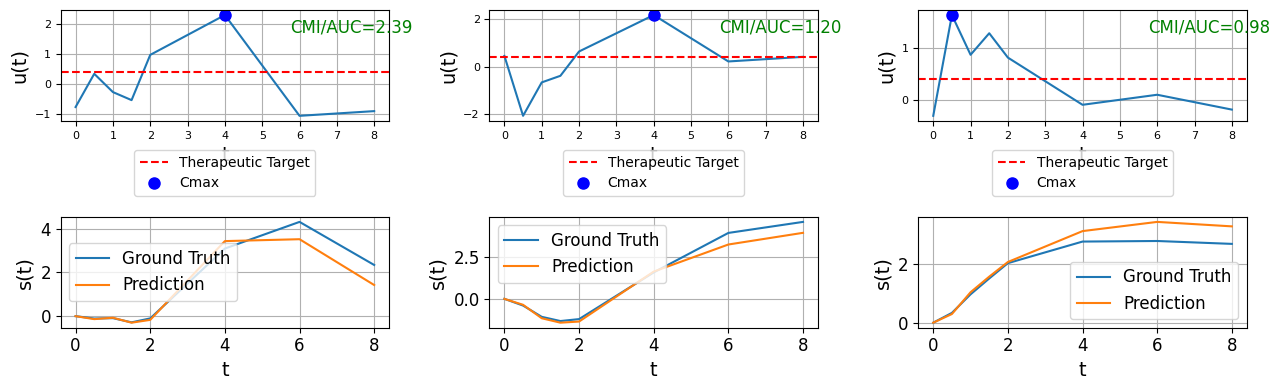

In [ ]:
# Spot check
%matplotlib inline
fig, axs = plt.subplots(2, 3, figsize=(13, 4))
sample_id = np.random.choice(np.arange(0, 8), size=3, replace=False)
for i in range(3):
    ax = axs[0, i]
    ax.plot(time_data.flatten(), X_test[sample_id[i]*8, 1:-1])
    ax.set_xlabel('t', fontsize=14)
    ax.set_ylabel('u(t)', fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=8)
    ax.grid(True)
                  # Calculate AUC (Area Under the Curve)
    auc = np.trapz(X_test[sample_id[i]*8, 1:-1], time_data.flatten())
    print(f'AUC for Plot {i + 1}: {auc}')
    # Define MIC (Minimum Inhibitory Concentration) for your antibiotic
    MIC = 0.1  # Example MIC value
    # Determine the Therapeutic Window (e.g., 4xMIC)
    therapeutic_window = 4 * MIC
    # Highlight Therapeutic Target
    ax.axhline(therapeutic_window, color='red', linestyle='--', label='Therapeutic Target')
    ax.legend()
    # Calculate CMI (Cumulative Minimum Inhibitory Concentration)
    cmi = np.trapz(np.maximum(X_test[sample_id[i]*8, 1:-1] - MIC, 0), time_data.flatten())
    # Calculate CMI/AUC
    cmi_over_auc = cmi / auc
    print(f'CMI for Plot {i + 1}: {cmi}')
    print(f'CMI/AUC for Plot {i + 1}: {cmi_over_auc}')
    print('***************************************************************')
    # Highlight Cmax (maximum concentration)
    cmax_index = np.argmax(X_test[sample_id[i]*8, 1:-1])
    cmax_time = time_data[cmax_index]
    cmax_concentration = X_test[sample_id[i]*8, 1:-1][cmax_index]
    ax.plot(cmax_time, cmax_concentration, 'bo', markersize=8, label='Cmax')
    # Move the legend below the plot
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2))


# Add text annotation for CMI/AUC value with color
    ax.annotate(f'CMI/AUC={cmi_over_auc:.2f}', xy=(0.7, 0.8), xycoords='axes fraction', fontsize=12, color='green')

    ax = axs[1, i]
    ax.plot(time_data.flatten(), y_test[sample_id[i]*8:(sample_id[i]+1)*8, :], label="Ground Truth")
    ax.plot(time_data.flatten(), pred_test[sample_id[i]*8:(sample_id[i]+1)*8, :], label="Prediction")
    ax.set_xlabel('t', fontsize=14)
    ax.set_ylabel('s(t)', fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.grid(True)
    ax.legend(prop={'size': 12})

plt.tight_layout()
plt.savefig('testing.png', bbox_inches='tight', transparent=True)

In [ ]:
#RMSE Comparison for Different Length Scales: The model's performance is evaluated on test datasets with different length scales.
#For each length scale, a test dataset is generated using the generate_dataset function.
# Create test dataset
N_test = 100
length_scale_test = 0.2
X, y = generate_dataset(N_test, length_scale_test, ODE_solve=True)

100%|██████████| 100/100 [00:00<00:00, 337.64it/s]


In [ ]:
#The model's predictions are obtained, and the RMSE is calculated. The RMSE values for different length scales are stored in a list

# Make prediction
pred = PI_DeepONet.predict({"cc": X[:, 1:-1], "time": X[:, :1]}, batch_size=12800)

# Overall accuarcy
print(f"RMSE: {mean_squared_error(y.flatten(), pred.flatten(), squared=False):.4e}")

1/1 [==============================] - 0s 37ms/step
RMSE: 6.7649e-01


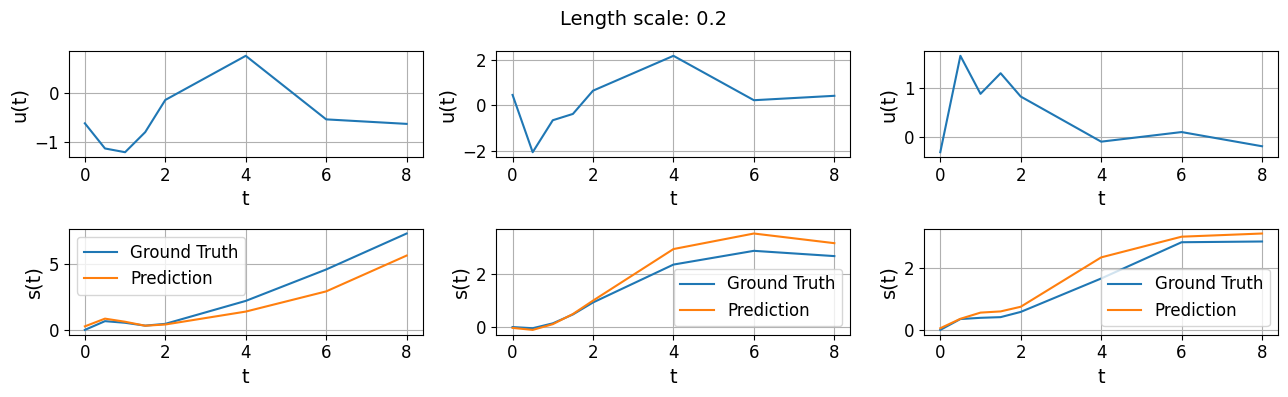

In [ ]:
# Spot check
%matplotlib inline
fig, axs = plt.subplots(2, 3, figsize=(13, 4))
sample_id = np.random.choice(np.arange(0, 8), size=3, replace=False)
for i in range(3):
    ax = axs[0, i]
    ax.plot(time_data.flatten(), X_test[sample_id[i]*8, 1:-1])
    ax.set_xlabel('t', fontsize=14)
    ax.set_ylabel('u(t)', fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.grid(True)


    ax = axs[1, i]
    ax.plot(time_data.flatten(), y[sample_id[i]*8:(sample_id[i]+1)*8, :], label="Ground Truth")
    ax.plot(time_data.flatten(), pred[sample_id[i]*8:(sample_id[i]+1)*8, :], label="Prediction")
    ax.set_xlabel('t', fontsize=14)
    ax.set_ylabel('s(t)', fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.grid(True)
    ax.legend(prop={'size': 12})

fig.suptitle(f'Length scale: {length_scale_test}', fontsize=14)
plt.tight_layout()
plt.savefig('testing_OOD.png', bbox_inches='tight', transparent=True)

In [ ]:
length_scale_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
RMSE = []
for length_scale in length_scale_list:
    # Create test dataset
    N_test = 100
    X, y = generate_dataset(N_test, length_scale, ODE_solve=True)

    # Make prediction
    pred = PI_DeepONet.predict({"cc": X[:, 1:-1], "time": X[:, :1]}, batch_size=12800)

    # Overall accuarcy
    RMSE.append(mean_squared_error(y.flatten(), pred.flatten(), squared=False))

100%|██████████| 100/100 [00:00<00:00, 351.53it/s]


1/1 [==============================] - 0s 41ms/step


100%|██████████| 100/100 [00:00<00:00, 326.67it/s]


1/1 [==============================] - 0s 47ms/step


100%|██████████| 100/100 [00:00<00:00, 203.51it/s]


1/1 [==============================] - 0s 56ms/step


100%|██████████| 100/100 [00:00<00:00, 245.53it/s]


1/1 [==============================] - 0s 71ms/step


100%|██████████| 100/100 [00:00<00:00, 230.24it/s]


1/1 [==============================] - 0s 64ms/step


100%|██████████| 100/100 [00:00<00:00, 251.43it/s]


1/1 [==============================] - 0s 58ms/step


100%|██████████| 100/100 [00:00<00:00, 231.90it/s]


1/1 [==============================] - 0s 54ms/step


***Generate RMSE Comparison Bar Plot: Barplot for generalization capability***




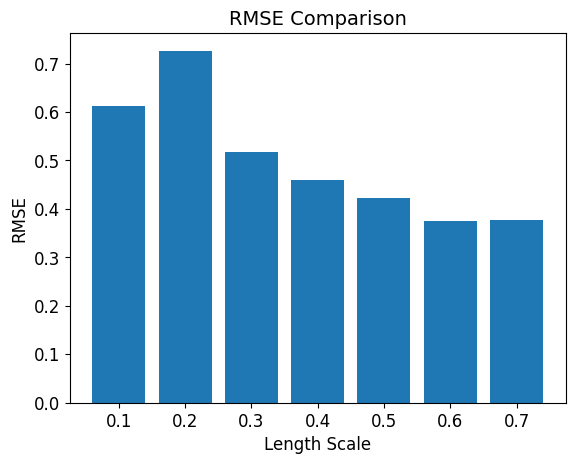

In [ ]:
# A bar plot is generated to visually compare the RMSE values of the model's predictions for different length scales.
#The x-axis represents the length scales, and the y-axis represents the RMSE values.
# This plot helps in assessing how the model's performance varies for different types of data distributions.

# Generate bar plot
plt.bar(range(len(RMSE)), RMSE)

# Set x-axis tick labels
plt.xticks(range(len(RMSE)), length_scale_list)

# Set x and y axis labels
plt.xlabel('Length Scale', fontsize=12)
plt.ylabel('RMSE', fontsize=12)
plt.tick_params(axis='both', which='major', labelsize=12)

# Set a title for the plot
plt.title('RMSE Comparison', fontsize=14)

# Save the plot
plt.savefig('testing_OOD_bar.png', bbox_inches='tight', transparent=True)